In [106]:
import pandas as pd
import datetime, warnings, scipy 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly import tools

from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

### Load data base

In [107]:
# train dataset
df_train = pd.read_csv('input/train_features.csv')
df_target = pd.read_csv('input/train_target.csv')
df_train['DelayTime'] = df_target['DelayTime']
df_train = df_train.dropna(subset=['TailNum', 'CRSElapsedTime'])

# test dataset
df_test = pd.read_csv('input/test_features.csv')

In [108]:
df_train.head()

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,CRSElapsedTime,Origin,Dest,Distance,DelayTime
0,2008,4,23,3,700,907,US,1195,N119US,307.0,PHL,PHX,2075,15.0
1,2008,7,18,5,2154,2349,US,401,N637AW,115.0,PHX,SFO,651,40.0
2,2008,12,21,7,1921,1949,NW,1767,N782NC,88.0,DTW,MSN,312,31.0
3,2008,4,24,4,1955,2020,WN,1865,N272WN,145.0,SAT,PHX,843,71.0
4,2008,6,27,5,1700,1848,OH,5186,N804CA,108.0,ORF,CVG,485,15.0


In [119]:
df_train

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,CRSElapsedTime,Origin,Dest,Distance,DelayTime,Date,DEPARTURE_TIME,ARRIVAL_TIME,DELAY_LEVEL
0,2008,4,23,3,700,907,US,1195,N119US,307.0,PHL,PHX,2075,15.0,2008-04-23,07:00:00,09:07:00,1
1,2008,7,18,5,2154,2349,US,401,N637AW,115.0,PHX,SFO,651,40.0,2008-07-18,21:54:00,23:49:00,1
2,2008,12,21,7,1921,1949,NW,1767,N782NC,88.0,DTW,MSN,312,31.0,2008-12-21,19:21:00,19:49:00,1
3,2008,4,24,4,1955,2020,WN,1865,N272WN,145.0,SAT,PHX,843,71.0,2008-04-24,19:55:00,20:20:00,2
4,2008,6,27,5,1700,1848,OH,5186,N804CA,108.0,ORF,CVG,485,15.0,2008-06-27,17:00:00,18:48:00,1
5,2008,9,28,7,640,811,NW,1424,N779NC,91.0,MCI,MEM,392,21.0,2008-09-28,06:40:00,08:11:00,1
6,2008,5,5,1,2030,2345,AA,185,N327AA,375.0,JFK,LAX,2475,61.0,2008-05-05,20:30:00,23:45:00,2
7,2008,3,10,1,2015,2309,US,186,N605AW,354.0,FLL,LAS,2174,52.0,2008-03-10,20:15:00,23:09:00,1
8,2008,1,26,6,1025,1045,EV,4199,N708EV,80.0,ATL,VPS,264,10.0,2008-01-26,10:25:00,10:45:00,1
9,2008,6,23,1,720,835,B6,1002,N239JB,75.0,JFK,BOS,187,32.0,2008-06-23,07:20:00,08:35:00,1


In [109]:
def format_time(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400:
            chaine = 0
        chaine = '{0:04d}'.format(int(chaine))
        time = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return time

def format_data(df):
    my_dict = {
        'Year': df.Year,
        'Month': df.Month,
        'Day': df.DayofMonth
        }
    date = pd.to_datetime(pd.DataFrame(my_dict))
    df['Date'] = date
    df['DEPARTURE_TIME'] = df['CRSDepTime'].apply(format_time)
    df['ARRIVAL_TIME'] = df['CRSArrTime'].apply(format_time)
    return df

df_test = format_data(df_test)
df_train = format_data(df_train)

In [110]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = df_train['DelayTime'].groupby(df_train['UniqueCarrier']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,count,max,mean,min
UniqueCarrier,,,,
AQ,520.0,336.0,26.969231,6.0
HA,5366.0,963.0,33.182818,6.0
F9,19682.0,805.0,27.709328,6.0
AS,27577.0,920.0,38.369692,6.0
9E,36171.0,1127.0,47.501064,6.0
OH,36960.0,960.0,49.032386,6.0
B6,38543.0,976.0,55.058428,6.0
YV,46932.0,607.0,55.263189,6.0
FL,49763.0,939.0,42.535177,6.0


In [121]:
global_stats_el = df_train['CRSElapsedTime'].groupby(df_train['UniqueCarrier']).apply(get_stats).unstack()
global_stats_el = global_stats_el.sort_values('count')
global_stats_el

,count,max,mean,min
UniqueCarrier,,,,
AQ,520.0,375.0,129.340385,29.0
HA,5366.0,505.0,131.693440,27.0
F9,19682.0,405.0,144.398181,70.0
AS,27577.0,440.0,152.987054,24.0
9E,36171.0,351.0,102.516795,17.0
OH,36960.0,320.0,113.604410,25.0
B6,38543.0,605.0,182.138910,18.0
YV,46932.0,227.0,91.165303,32.0
FL,49763.0,355.0,128.322047,57.0


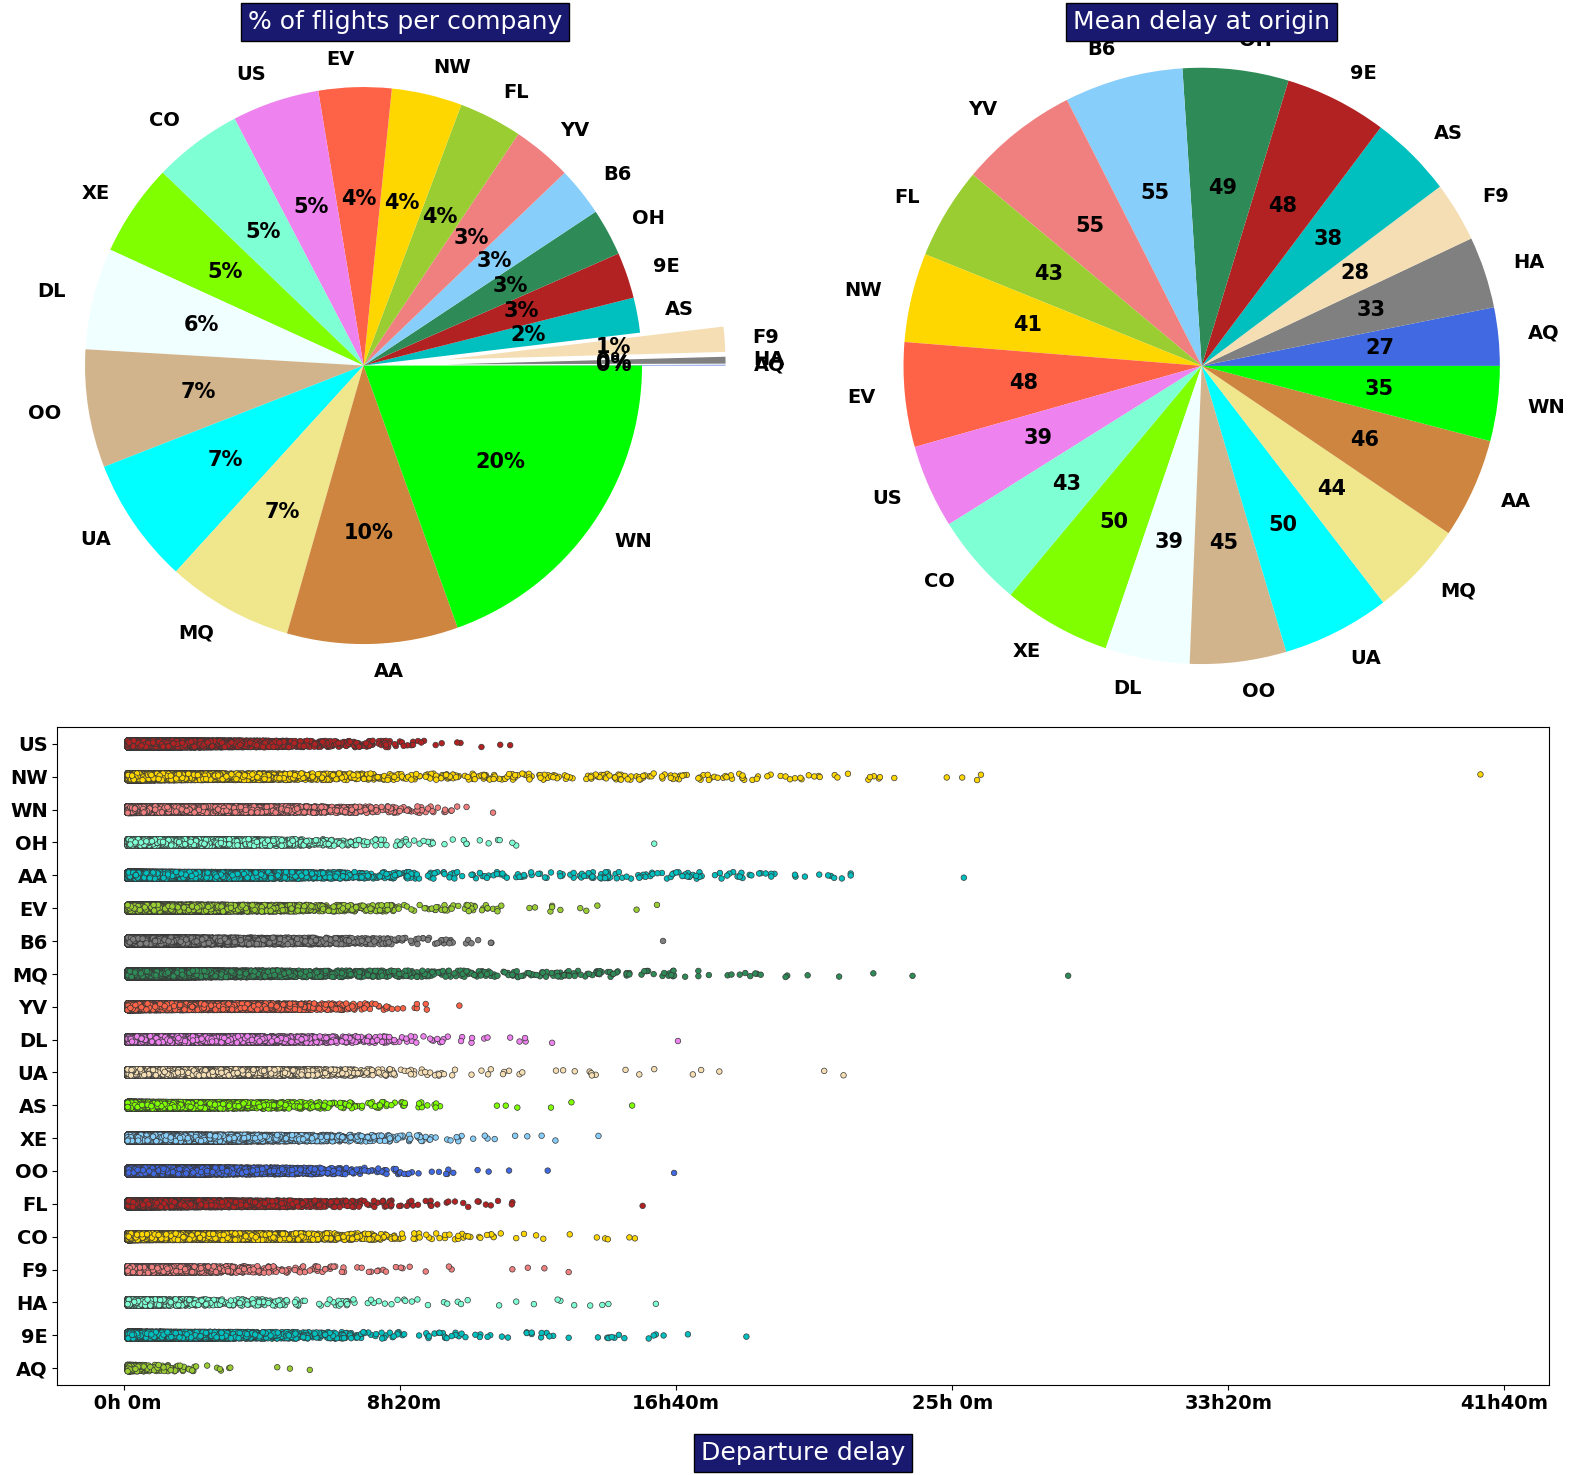

In [111]:
import matplotlib.patches as mpatches
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 15}
mpl.rc('font', **font)
#__________________________________________________________________
# I extract a subset of columns and redefine the airlines labeling 
df2 = df_train.loc[:, ['UniqueCarrier', 'DelayTime']]
#________________________________________________________________________
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse',
          'azure', 'tan', 'cyan', 'khaki', 'peru', 'lime']
#___________________________________
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 
ax3=fig.add_subplot(gs[1,:]) 
#------------------------------
# Pie chart nº1: nb of flights
#------------------------------
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.3 if sizes[i] < 20000 else 0.0 for i in range(np.unique(df_train['UniqueCarrier']).shape[0])]
patches, texts, autotexts = ax1.pie(sizes, explode = explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
for i in range(np.unique(df_train['UniqueCarrier']).shape[0]): 
    texts[i].set_fontsize(14)
ax1.axis('equal')
ax1.set_title('% of flights per company', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=18)
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(np.unique(df_train['UniqueCarrier']).shape[0]):
    comp_handler.append(mpatches.Patch(color=colors[i], label = global_stats.index[i]))
# ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9), 
#            fontsize = 13, bbox_transform=plt.gcf().transFigure)
#----------------------------------------
# Pie chart nº2: mean delay at departure
#----------------------------------------
sizes  = global_stats['mean'].values
sizes  = [max(s,0) for s in sizes]
explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(np.unique(df_train['UniqueCarrier']).shape[0])]
patches, texts, autotexts = ax2.pie(sizes, explode = explode, labels = labels,
                                colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(np.unique(df_train['UniqueCarrier']).shape[0]): 
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Mean delay at origin', bbox={'facecolor':'midnightblue', 'pad':5},
              color='w', fontsize=18)
#------------------------------------------------------
# striplot with all the values reported for the delays
#___________________________________________________________________
# I redefine the colors for correspondance with the pie charts
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue']
#___________________________________________________________________
ax3 = sns.stripplot(y="UniqueCarrier", x="DelayTime", size = 4, palette = colors,
                    data=df2, linewidth = 0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Departure delay', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)
#________________________
plt.tight_layout(w_pad=3) 

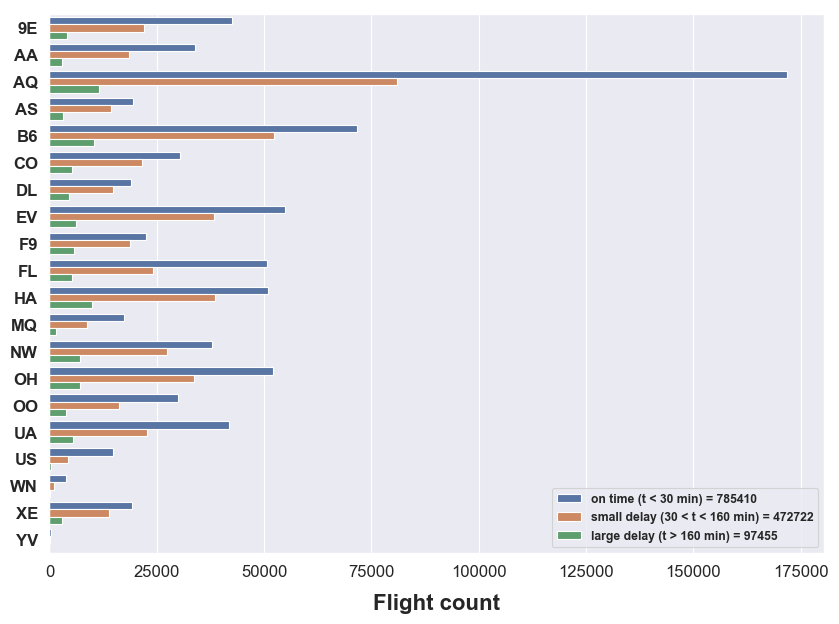

In [193]:
#_____________________________________________
# Function that define how delays are grouped
t1 = 30
t2 = 160
delay_type = lambda x:((0,1)[x > 30],2)[x > 120]
df_train['DELAY_LEVEL'] = df_train['DelayTime'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="UniqueCarrier", hue='DELAY_LEVEL', data=df_train)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = np.unique(df_train['UniqueCarrier'])
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
unique, counts = np.unique(df_train.DELAY_LEVEL, return_counts=True)
L.get_texts()[0].set_text('on time (t < %d min) = %d' % (t1, counts[0]))
L.get_texts()[1].set_text('small delay (%d < t < %d min) = %d' % (t1, t2, counts[1]))
L.get_texts()[2].set_text('large delay (t > %d min) = %d' % (t2, counts[2]))
plt.show()

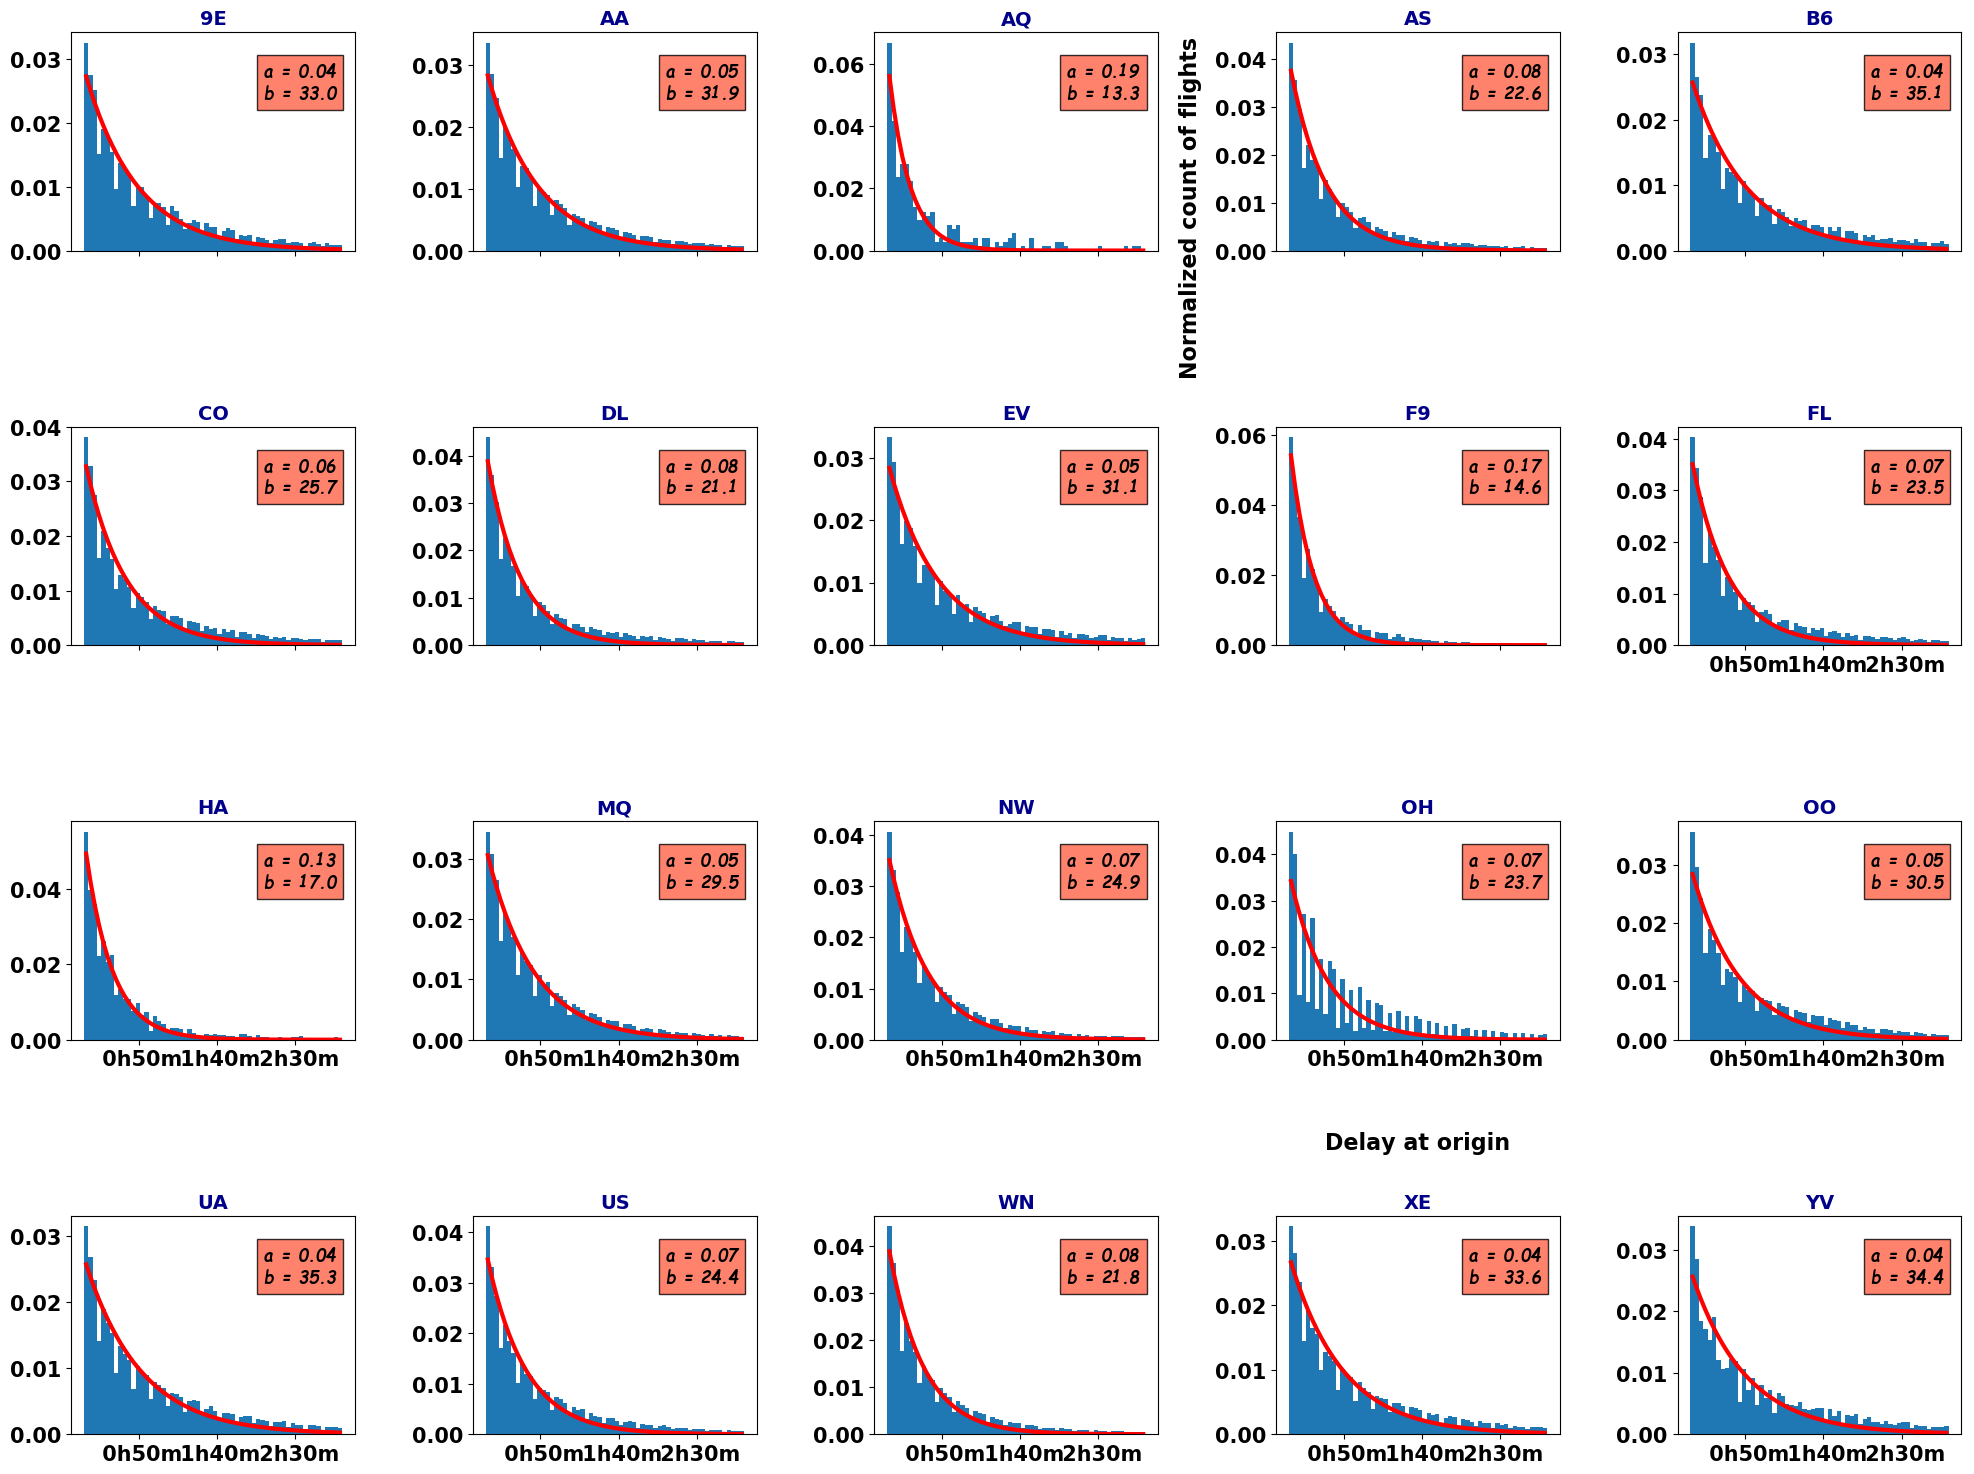

In [113]:
#___________________________________________
# Model function used to fit the histograms
def func(x, a, b):
    return a * np.exp(-x/b)
#-------------------------------------------
points = [] ; label_company = []
fig = plt.figure(1, figsize=(20,15))
i = 0
for carrier_name in np.unique(df_train['UniqueCarrier']):
    i += 1
    ax = fig.add_subplot(4,5,i)    
    #_________________________
    # Fit of the distribution
    n, bins, patches = plt.hist(x = df2[df2['UniqueCarrier']==carrier_name]['DelayTime'],
                                range = (15,180), normed=True, bins= 60)
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])    
    popt, pcov = curve_fit(func, bin_centers, n, p0 = [1, 2])
    #___________________________
    # bookeeping of the results
    points.append(popt)
    label_company.append(carrier_name)
    #______________________
    # draw the fit curve
    plt.plot(bin_centers, func(bin_centers, *popt), 'r-', linewidth=3)    
    #_____________________________________
    # define tick labels for each subplot
    if i < 10:
        ax.set_xticklabels(['' for x in ax.get_xticks()])
    else:
        ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                            for x in ax.get_xticks()])
    #______________
    # subplot title
    plt.title(carrier_name, fontsize = 14, fontweight = 'bold', color = 'darkblue')
    #____________
    # axes labels 
    if i == 4:
        ax.text(-0.3,0.9,'Normalized count of flights', fontsize=16, rotation=90,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    if i == 14:
        ax.text( 0.5, -0.5 ,'Delay at origin', fontsize=16, rotation=0,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    #___________________________________________
    # Legend: values of the a and b coefficients
    ax.text(0.68, 0.7, 'a = {}\nb = {}'.format(round(popt[0],2), round(popt[1],1)),
            style='italic', transform=ax.transAxes, fontsize = 12, family='fantasy',
            bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':5})
    
plt.tight_layout()

In [148]:
origin_nb = dict()
for carrier in np.unique(df_train['UniqueCarrier']):
    liste_origin_airport = df_train[df_train['UniqueCarrier'] == carrier]['Origin'].unique()
    origin_nb[carrier] = len(liste_origin_airport)

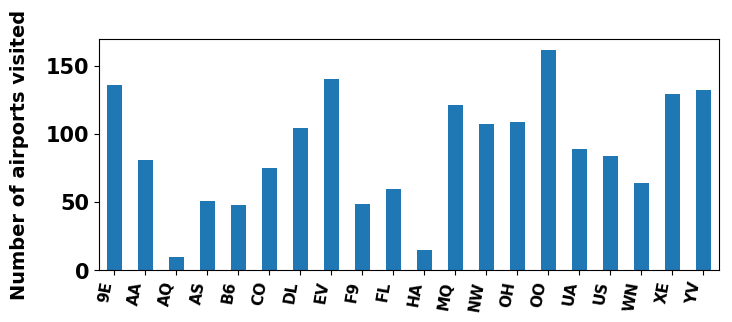

In [150]:
test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns = {0:'count'}, inplace = True)
ax = test_df.plot(kind='bar', figsize = (8,3))
labels =  np.unique(df_train['UniqueCarrier'])
ax.set_xticklabels(labels)
plt.ylabel('Number of airports visited', fontsize=14, weight = 'bold', labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha = 'right', rotation = 80)
ax.legend().set_visible(False)
plt.show()

In [154]:
airport_mean_delays = pd.DataFrame(pd.Series(df_train['Origin'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)

for carrier in  np.unique(df_train['UniqueCarrier']):
    df1 = df_train[df_train['UniqueCarrier'] == carrier]
    test = df1['DelayTime'].groupby(df_train['Origin']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean'] 

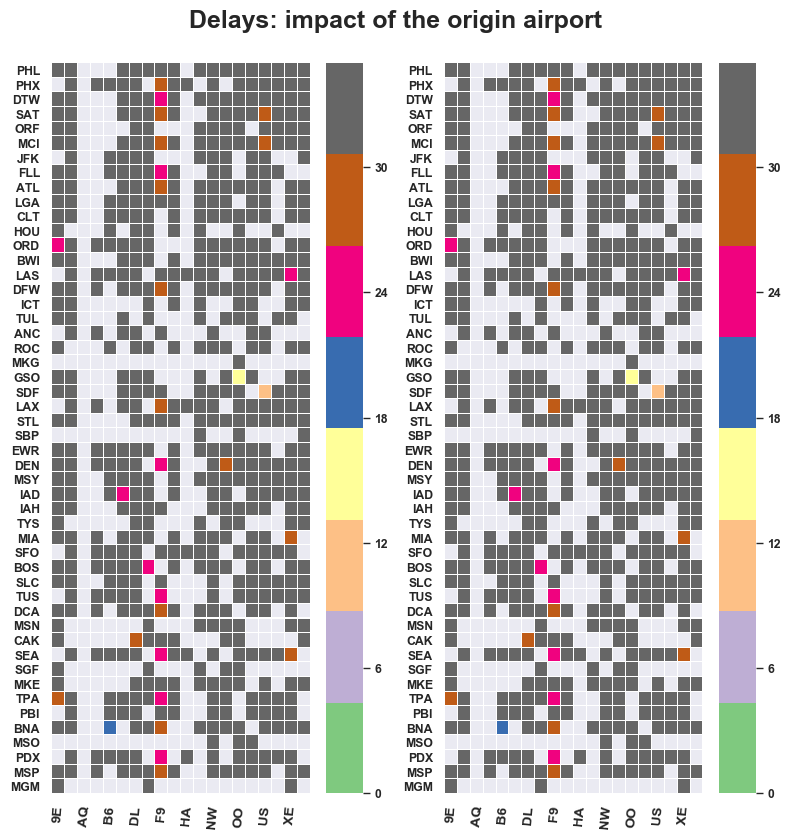

In [158]:
sns.set(context="paper")
fig = plt.figure(1, figsize=(8,8))

ax = fig.add_subplot(1,2,1)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,2,2)    
fig.text(0.5, 1.02, "Delays: impact of the origin airport", ha='center', fontsize = 18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

plt.tight_layout()

In [160]:
df_train_1 = df_train.loc[df_train['DELAY_LEVEL'] == 2]

In [161]:
df_train_1.head()

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,CRSElapsedTime,Origin,Dest,Distance,DelayTime,Date,DEPARTURE_TIME,ARRIVAL_TIME,DELAY_LEVEL
3,2008,4,24,4,1955,2020,WN,1865,N272WN,145.0,SAT,PHX,843,71.0,2008-04-24,19:55:00,20:20:00,2
6,2008,5,5,1,2030,2345,AA,185,N327AA,375.0,JFK,LAX,2475,61.0,2008-05-05,20:30:00,23:45:00,2
10,2008,3,19,3,2020,2205,MQ,4891,N703MR,105.0,LGA,CLE,418,230.0,2008-03-19,20:20:00,22:05:00,2
27,2008,1,17,4,904,1043,YV,7146,N505MJ,159.0,ORD,COS,911,62.0,2008-01-17,09:04:00,10:43:00,2
36,2008,8,15,5,1545,1725,DL,234,N655DL,100.0,JFK,BOS,187,74.0,2008-08-15,15:45:00,17:25:00,2


In [162]:
def data_preproc(df):
    df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].map(lambda x:x.hour*3600+x.minute*60+x.second)
    df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].map(lambda x:x.hour*3600+x.minute*60+x.second)
    
    variables_to_remove = ['Year', 'Month', 'DayofMonth', 
                           'DayOfWeek', 'CRSDepTime', 'CRSArrTime',
                           'CRSElapsedTime']
    df.drop(variables_to_remove, axis=1, inplace=True)
    
    cols = ["UniqueCarrier", "TailNum" ,"Dest", "Origin", "Date"]

    for item in cols:
        df[item] = df[item].astype("category").cat.codes + 1
        
    return df

In [163]:
train = data_preproc(df_train_1)
# test = data_preproc(df_test)

train = train.drop(['FlightNum', 'TailNum', 'DELAY_LEVEL'], axis=1)
# test = test.drop(['FlightNum', 'TailNum'], axis=1)

In [164]:
train.head()

,UniqueCarrier,Origin,Dest,Distance,DelayTime,Date,DEPARTURE_TIME,ARRIVAL_TIME
3,18,247,220,843,71.0,115,71700,73200
6,2,149,157,2475,61.0,126,73800,85500
10,12,161,61,418,230.0,79,73200,79500
27,20,209,68,911,62.0,17,32640,38580
36,7,149,37,187,74.0,228,56700,62700


In [165]:
Y = train["DelayTime"]
X = train.drop('DelayTime', axis=1)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, 
                                                    random_state=42)

cols = ["UniqueCarrier","Dest", "Origin", "Date"]
    
# Prepare Categorical Variables
def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]
categorical_features_pos = column_index(x_train, cols)

In [166]:
print(categorical_features_pos)
x_train.head()

[0 2 1 4]


,UniqueCarrier,Origin,Dest,Distance,Date,DEPARTURE_TIME,ARRIVAL_TIME
460175,12,61,81,1021,169,56100,62700
27709,15,247,210,1041,49,62580,72300
683904,2,209,126,1009,33,46200,52800
9660,18,80,175,533,57,54300,63300
815246,18,48,246,919,108,63900,73200


In [167]:
cbr = CatBoostRegressor(iterations=1000,
                        max_depth=10,
                        learning_rate=0.01,
                        bagging_temperature = 0.5,
                        od_wait=100,
                        eval_metric='RMSE',
                        od_type='Iter',
                        random_seed = 42,
                        task_type='GPU')


cbr.fit(x_train, y_train, eval_set=(x_test, y_test), 
        cat_features=categorical_features_pos,
        use_best_model=True,
        plot=True, 
        verbose_eval=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [129]:
cb_pred = cbr.predict(test)
pd.Series(cb_pred, name='DelayTime').to_csv('output/CBR.csv', 
                                            index_label='id', header=True)